# Control Dinámico de un robot RR planar

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oscar-ramos/fundamentos-robotica-python/blob/main/8-Control-Movimiento/8-1-Control-RR.ipynb)

* Oscar E. Ramos Ponce, Universidad de Ingeniería y Tecnología - UTEC
* Fundamentos de Robótica

Este archivo contiene algunos ejemplos de control dinámico

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Usar una ventana para la simulación
#%matplotlib qt

## Robot RR en dinámica

Clase que define la dinámica analítica del robot RR

In [5]:
class RobotRR(object):
    """
    Robot RR
    """
    def __init__(self, X0, dt, gravedad=True):
        """
        X0 - Estado inicial: [q1, q2, dq1, dq2]
        dt - diferencial de tiempo usado para la integración de Euler
        """
        # Parámetros del robot
        self.m1=50; self.m2=50       # kg
        self.Lc1=0.5; self.Lc2=0.5   # m
        self.L1=1; self.L2=1         # m
        self.I1=10; self.I2=10       # kg.m^2
        self.dt = dt
        self.X = X0
        self.gravedad = gravedad
        
    def simular(self, u):
        """
        Simulación: retorna los estados dado un control u
        """
        # Valores articulares
        q1 = self.X[0]; q2 = self.X[1]
        # Velocidades articulares
        dq1 = self.X[2]; dq2 = self.X[3]

        # Matriz de inercia
        m11 = self.m1*self.Lc1**2 + self.m2*(self.L1**2+self.Lc2**2+2*self.L1*self.Lc2*np.cos(q2)) + self.I1 + self.I2
        m12 = self.m2*(self.L1*self.Lc2*np.cos(q2)+self.Lc2**2) + self.I2
        m22 = self.m2*self.Lc2**2 + self.I2
        M = np.array([[m11, m12],[m12, m22]])

        # Matriz de Coriolis y fuerza centrifuga
        h = -self.m2*self.L1*self.Lc2*np.sin(q2)
        C = np.array([[h*dq2, h*(dq1+dq2)],[-h*dq1, 0.0]])

        # Componente de gravedad
        if self.gravedad:
            g = 9.81*np.array([(self.m1*self.Lc1+self.m2*self.L1)*np.cos(q1)+self.m2*self.Lc2*np.cos(q1+q2),
                                self.m2*self.Lc2*np.cos(q1+q2)])
        else:
            g = np.array([0,0])

        # Aplicación del control al robot (actualización del estado)
        ddq = -np.linalg.inv(M).dot( C.dot(np.array([dq1,dq2])) + g - u)
        dq = np.array([dq1,dq2])
        dX = np.hstack((dq,ddq))
        # Integración de Euler
        self.X = self.X + self.dt*dX
        return self.X
    
    def plot(self, show_axis=True, k=0.25):
        """
        Grafica el robot RR
        """
        # Cinemática directa
        x1 = np.cos(self.X[0]); y1 = np.sin(self.X[0])
        x2 = x1+np.cos(self.X[0]+self.X[1]); y2 = y1+np.sin(self.X[0]+self.X[1])
        plt.clf()
        # Cuerpo del robot
        plt.plot([0, x1],[0, y1], linewidth=3, color='b')
        plt.plot([x1, x2],[y1, y2], linewidth=3, color='b')
        # Puntos en las articulaciones
        plt.plot(0, 0, color='r', marker='o', markersize=8)
        plt.plot(x1, y1, color='r', marker='o', markersize=8)
        # Plot
        plt.axis((-2, 2,-2, 2))
        plt.grid('on')

## Simulación del Controlador

### Robot simulado

Se crea una instancia del robot usando únicamente el estado inicial y el tiempo de muestreo que se utilizará para actualizar los estados (con integración de Euler)

In [6]:
# Tiempo de muestreo
dt = 0.01

# Condiciones iniciales: [q1,q2,dq1,dq2]
X = np.array([0, 0, 0, 0])

# Crear instancia de robot
robot = RobotRR(X, dt)

Se definen algunos parámetros adicionales como el tiempo de simulación y los parámetros dinámicos estimados del robot (en un sistema real no se conoce los parámetros exactos sino solo las aproximaciones)

In [7]:
# Tiempo final de simulación (modificar si es necesario)
Tf = 4
# Tiempo de simulacion
t = np.arange(0, Tf, dt)

# Parámetros "estimados" del robot
m1 = 50; m2 = 50       # kg
Lc1 = 0.5; Lc2 = 0.5   # m
L1 = 1;  L2 = 1        # m
I1 = 10; I2 = 10       # kg.m^2

# Graficar robot? (True/False)
doplot = False

# Valor articular deseado: [q1d, q2d]
qdes = np.array([0.5, 0.5])

El bucle principal implementa algún esquema de control dinámico

In [22]:
# Variables para almacenar estados y control
Xt = np.zeros((len(t),4))
Ut = np.zeros((len(t),2))

# Bucle principal
for i in range(len(t)):
    
    # Inicialización del control a cero (por defecto)
    u = np.array([0, 0])
    
    # Control PD
    if (True):
        Kp = 2000*np.eye(2)
        Kd = 100*np.eye(2)
        e = qdes - X[0:2]
        u = Kp.dot(e) - Kd.dot(X[2:])   #PD
    
    # Control PD + compensación de gravedad
    elif (False):
        Kp = 1000*np.eye(2)
        Kd = 700*np.eye(2)
        e = qdes - X[0:2]
        # Compensación de gravedad
        q1 = X[0]; q2 = X[1]
        g = np.array([(m1*Lc1+m2*L1)*np.cos(q1)+m2*Lc2*np.cos(q1+q2), 
                       m2*Lc2*np.cos(q1+q2)])*9.81
        u = Kp.dot(e) - Kd.dot(X[2:]) + g    # PD + gravedad

    # Simulación de la dinámica
    X = robot.simular(u)
    
    # Gráfico
    if (doplot):
        robot.plot()
        plt.pause(0.0001)   

    # Almacenar estados y control
    Xt[i,:] = X
    Ut[i,:] = u

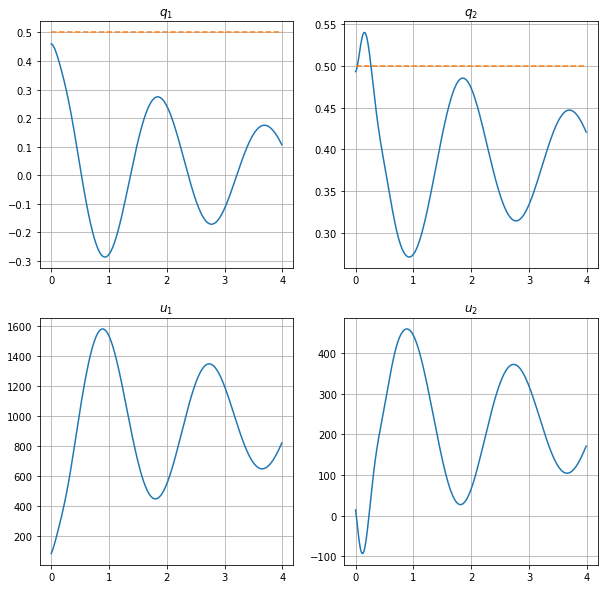

In [23]:
plt.figure(figsize=(10,10))
# Posiciones
plt.subplot(2,2,1); plt.plot(t, Xt[:,0]); plt.plot(t, qdes[0]*np.ones(len(t)), '--')
plt.title('$q_1$'); plt.grid()
plt.subplot(2,2,2); plt.plot(t, Xt[:,1]); plt.plot(t, qdes[1]*np.ones(len(t)), '--')
plt.title('$q_2$'); plt.grid()
# Torques
plt.subplot(2,2,3); plt.plot(t, Ut[:,0]); plt.title('$u_1$'); plt.grid()
plt.subplot(2,2,4); plt.plot(t, Ut[:,1]); plt.title('$u_2$'); plt.grid()